In [1]:
import numpy as np                # Importa la libreria numpy para el cálculo con vectores
import matplotlib.pyplot as plt   # Importa la libreria matplotlib para relizar gáficas
# Este comando solo funciona dentro de Jupyter para permitir cierta
# interacción con las gráficas. Solo deberia usarse si esta dentro de Jupyter
import gc
import scipy.signal
%matplotlib notebook

In [71]:
class Fresnel:
        
    def __init__(self,wl,D,xmin,xmax,Nx,mask, flag = 0):
        # Función que se ejecutará al crear el objeto 'Fresnel'. 
        # Se inicia con los diferentes parámetros: longitud de onda, 
        # distnancia rendija-pantalla, la máscara (1 en las zonas que pasa luz
        # y 0 zonas en las que no pasa luz), los extremos de la zona de integración,
        # y el número de puntos.
    
        # Las variables que llevan delante 'self.' son las variables que pueden
        # ser accedidas en toda la definición de la clase Fresnel. Las que no 
        # lleven el prfijo solamente podrá ser accedidas desde dentro de la función
        # en la que se encuentren definidas
        
        self.wl = wl        # Longitud de onda
        self.D = D          # Distancia rendija-pantalla
        self.mask = mask    # Máscara para definir la rendija
        self.xmin = xmin    # Extremo inferior de la zona de integración
        self.xmax = xmax    # Extremo superior de la zona de integración
        self.Nx = Nx        # Número de puntos
        self.flag = flag
        self.Init()         # Iniciza el mallado de integración
        
    def Init(self):
        # Crea un vector cuyos elementos son los puntos desde xmin hasta xmax.
        # En total habra Nx puntos y la separación enter punto y punto será
        # (xmax-xmin)/Nx
        self.x, self.dx = np.linspace(self.xmin,self.xmax,self.Nx,retstep=True)
        
    def h00(self):
        # Define la función correspondiente al propagador del fresnel
        # en las posiciones eta = 0, chi = 0. (Corresponderia con la PSF)
        
        # Redifinición de las variables para simplificar la notación
        wl = self.wl
        D = self.D
        x = self.x
        
        # Definición del vector de onda 
        k = 2*np.pi/wl
        
        # Devuelve un vector en el que sus componentes tienen el valor
        # del propagador de fresnel en cada punto del espacio. 
        # Al estar usando vectores (arrays) de la libreria numpy 
        # puede evaular directamente todo el vector sin tener que emplear
        # un bucle para cada elemento del vector 'x'
        return k/(1j*2*np.pi*D)*np.exp(1j*k*D)*np.exp(1j*k*x*x/(2*D))
    
    def Propagate(self):
        #   Se realiza la integral de fresnel. Sin embargo en vez de 
        # implementar un algoritmo de integración como podría ser el
        # algoritmo de simpson o una cuadratura, se resuelve realziando
        # la convolución del propagador de fresnel y de la máscara que 
        # atraviesa la luz (la rendija). 
        #   La convulción se realiza calculando las transformadas de fourier
        # de ambas funciones (sus correspondientes arrays) empleando 
        # la librería numpy (np) a traves de la función fft.
        #   Una vez calculadas las transformadas, se multiplican elemento a elemento,
        # y la convolución se obtendrá como la transformada inversa del producto 
        # anterior
        
        
        self.ffth00 = np.fft.fft(np.fft.fftshift(self.h00()))*self.dx             #   Calcula la transformada del propagador
        self.ffth00 = np.fft.ifftshift(self.ffth00)            #   Ordena los elementos. El resultado np.fft.fft devuelve
                                                    # primero los elementos correspondientes a frecuencias
                                                    # positivas y a continuación las frecuencias negativas.
                                                    # justamente al contrario de la forma deseada
        self.fftmask = np.fft.fft(np.fft.fftshift(self.mask))             #   Transformada de la máscara
        self.fftmask =  np.fft.ifftshift(self.fftmask)          #   Ordenación de los elementos
        
        self.fftconv = 1/np.sqrt(2*np.pi)*self.ffth00*self.fftmask #   Multiplica las dos transformadas de fourier
        
        conv = np.fft.ifft(np.fft.ifftshift(self.fftconv))     # Realiza las transformada inversa
        conv = np.fft.fftshift(conv)    # Ordena los elementos
        self.newField = conv             # Guarda el nuevo campo eléctrico

#         conv = scipy.signal.convolve(self.h00(),self.mask,mode='same')
#         self.newField = conv
        #self.newField = scipy.signal.convolve(self.mask,self.h00(),'same')
        
    def ReturnNewField(self):
        # Función que devuelve el campo eléctrico
        return self.newField
    def ReturnPhase(self):
        return np.arctan(self.newField.imag/self.newField.real)
    def ReturnNewIntensity(self):
        # Función que devuelve la intesidad (cuadrado del campo eléctrico)
        intensity = np.conjugate(self.newField)*self.newField
        #intensityN = intensity/np.max(intensity) # Normaliza al máxmo para eviar valores extremos
        return intensity
    
class Lens:
    def __init__(self,f,wl,x,n=1.0,d=0.0):
        self.x = x
        k = 2*np.pi/wl
        self.lens = np.exp(-1j*k*x*x/(2*f))    
    def Lens(self):
        return self.lens
    
class Slit:
    # Función que define la máscara de la rendija. 
    # Guarda en un array el valor 1.0 para los puntos dentro
    # de la rendija, y 0.0 en los puntos fuera de la redija
    def __init__(self,c, d, xmin, xmax, Nx):
        x = np.linspace(xmin,xmax,Nx) # Array espacial
        self.mask = np.zeros(x.shape)      # Array de la máscara con la misma forma que el array espacial. Inicia todos los elementos a 0.0
        for i in range(len(x)):       # Recorre todos los puntos espaciales y comprueba si está dentro o fuera de la rejilla
            if(abs(x[i]-c)<=d/2):
                self.mask[i] = 1.0
    def Slit(self):
        return self.mask

## Campo cercano por una rendija

In [3]:
wl = 500E-9         # Longitud de onda
xmin = -8E-3        # Extremo inferior de la zona de integración
xmax = 8E-3         # Extremo superior de la zona de integración
Nx = 500000         # Número de puntos para la coordenada espacial
D = 0.0005       # Distancia entre la rendija y la pantalla
x,dx = np.linspace(xmin,xmax,Nx,retstep=True) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Define la máscara
mask = Slit(0.0,0.051E-3,xmin,xmax,Nx).Slit()
#mask = np.power(np.sin(2*np.pi/2E-5*x),2)
#U = np.exp(-x*x/1E-5)*lens.Lens()
U = mask
fr = Fresnel(wl,D,xmin,xmax,Nx,U) # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
fr.Propagate() # Realiza el cáclulo


/home/rmhsik/Software/Coherente/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Distancia a la pantalla')

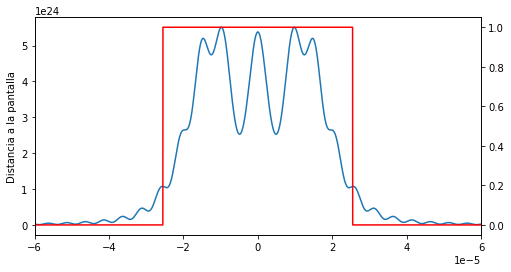

In [4]:

# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.plot(x,fr.ReturnNewIntensity())  # Representa la intensidad frente a la coordenada espacial
ax2 = ax.twinx()                    # Crea un sistema de ejes secundarios, compartiendo el eje x entre los dos plots
ax2.plot(x,mask,'r')                # En el nuevo plot dibuja la máscara en color rojo
ax.set_xlim(-6E-5,6E-5)             # Establece los límites de representación en el eje x
ax.set_ylabel('Distancia a la pantalla')
#plt.savefig('LenteFueraEje.png')

## Campo lejano por una rendija

In [37]:
wl = 633E-9         # Longitud de onda
xmin = -8E-1        # Extremo inferior de la zona de integración
xmax = 8E-1         # Extremo superior de la zona de integración
Nx = 5000000         # Número de puntos para la coordenada espacial
D = 2.0       # Distancia entre la rendija y la pantalla
x,dx = np.linspace(xmin,xmax,Nx,retstep=True) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Define la máscara
mask = Slit(0.0,0.051E-3,xmin,xmax,Nx).Slit()
#mask = np.power(np.sin(2*np.pi/2E-5*x),2)
#U = np.exp(-x*x/1E-5)*lens.Lens()
U = mask
fr = Fresnel(wl,D,xmin,xmax,Nx,U) # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
fr.Propagate() # Realiza el cáclulo


<IPython.core.display.Javascript object>


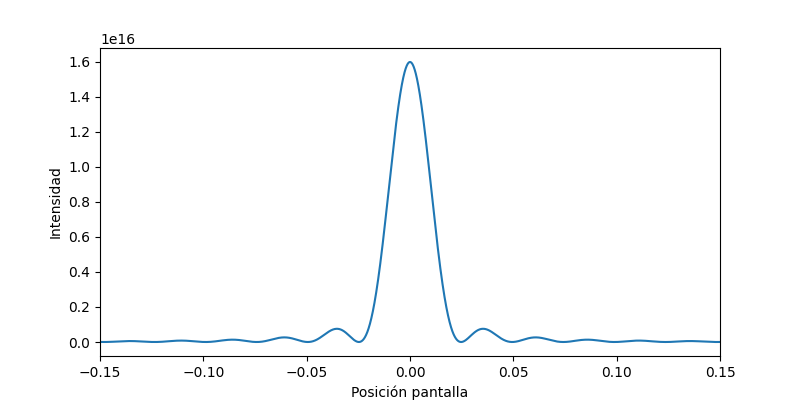

/home/rmhsik/Software/Coherente/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [40]:

# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.plot(x,fr.ReturnNewIntensity())  # Representa la intensidad frente a la coordenada espacial
#ax2 = ax.twinx()                    # Crea un sistema de ejes secundarios, compartiendo el eje x entre los dos plots
#ax2.plot(x,mask,'r')                # En el nuevo plot dibuja la máscara en color rojo
ax.set_xlim(-15E-2,15E-2)             # Establece los límites de representación en el eje x
ax.set_ylabel('Intensidad')
ax.set_xlabel('Posición pantalla')
#ax.set_yscale('log')
plt.savefig('RendijaLejano.png')

## Incidencia fuera del eje en una lente

In [3]:
wl = 633E-9         # Longitud de onda
xmin = -8E-3        # Extremo inferior de la zona de integración
xmax = 8E-3         # Extremo superior de la zona de integración
Nx = 1500000         # Número de puntos para la coordenada espacial
x = np.linspace(xmin,xmax,Nx) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Definición de las lentes
lens = Lens(0.6,wl,x)       

z = np.linspace(1E-5,1.2,100)   # Puntos a lo largo del eje z en los que se calculará la intensidad
IntensityArray = []

# Recorre todo los puntos en la dirección transversal
for i, zi in enumerate(z):
    # Se define la distancia de propagación
    D = zi

    # Campo gaussiano al inicio que atravesar la primera lente 
    U1 = np.exp(-(x-0.001)*(x-0.001)/2E-6)*lens.Lens()  

    # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
    fr = Fresnel(wl,D,xmin,xmax,Nx,U1) 
    fr.Propagate() # Realiza el cáclulo de la propagación
    Intensity = fr.ReturnNewIntensity() # Guarda el valor de la intensidad en un vector

    # Normaliza el valor de la intensidad respecto al valor máximo
    IntensityArray.append(Intensity/Intensity.max())  

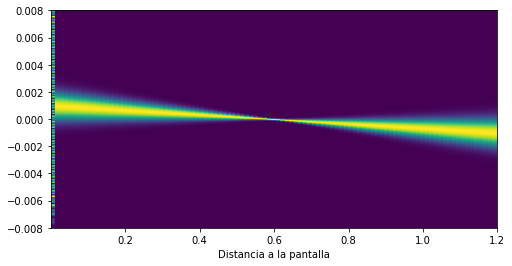

In [4]:
# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.pcolormesh(z,x,np.abs(np.array(IntensityArray).transpose()))  # Representa la intensidad frente a la coordenada espacial

#ax2.plot(x,U1,'r')                # En el nuevo plot dibuja la máscara en color rojo
#ax.set_xlim(-6E-5,6E-5)   
ax.set_xlabel('Distancia a la pantalla')
plt.savefig('LenteFueraEje.png')
#plt.close()

## Sistema de dos lentes

In [7]:
wl = 633E-9         # Longitud de onda
xmin = -8E-3        # Extremo inferior de la zona de integración
xmax = 8E-3         # Extremo superior de la zona de integración
Nx = 500000         # Número de puntos para la coordenada espacial
x = np.linspace(xmin,xmax,Nx) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Definición de las lentes
lens = Lens(0.2,wl,x)       
lens2 = Lens(0.1,wl,x)

z = np.linspace(1E-5,1.2,300)   # Puntos a lo largo del eje z en los que se calculará la intensidad
IntensityArray = []

# Recorre todo los puntos en la dirección transversal
for i, zi in enumerate(z):
    
    # 
    if zi <= 0.4:
        # Se define la distancia de propagación
        D = zi
        
        # Campo gaussiano al inicio que atravesar la primera lente 
        U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)*lens.Lens()  
        
        # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
        fr = Fresnel(wl,D,xmin,xmax,Nx,U1) 
        fr.Propagate() # Realiza el cáclulo de la propagación
        Intensity = fr.ReturnNewIntensity() # Guarda el valor de la intensidad en un vector
        
        # Normaliza el valor de la intensidad respecto al valor máximo
        IntensityArray.append(Intensity[::100]/Intensity.max())  


    else:
        # Se define el límite de la propagación hasta la posición de la segunda lente
        D = 0.4
        U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)*lens.Lens()
        fr = Fresnel(wl,D,xmin,xmax,Nx,U1)
        fr.Propagate() 
        
        # Se calcula la propagación hasta la posición zi desde la posición de la segunda lente,
        # a partir del campo calculado con el primer propagador.
        D = zi-D
        U2 = (fr.ReturnNewField())*lens2.Lens()
        fr2 = Fresnel(wl,D,xmin,xmax,Nx,U2,flag = 1)
        fr2.Propagate()
        Intensity = fr2.ReturnNewIntensity()
        IntensityArray.append(Intensity[::100]/Intensity.max())


<IPython.core.display.Javascript object>


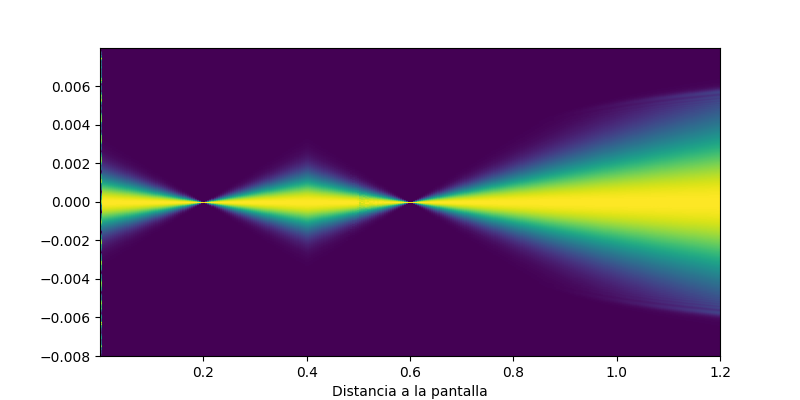

In [8]:

# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.pcolormesh(z,x[::100],np.abs(np.array(IntensityArray).transpose()))  # Representa la intensidad frente a la coordenada espacial

#ax2.plot(x,U1,'r')                # En el nuevo plot dibuja la máscara en color rojo
#ax.set_xlim(-6E-5,6E-5)   
ax.set_xlabel('Distancia a la pantalla')
plt.savefig('SistemaLentes.png')


## Sistema colimador de dos lentes

In [3]:
wl = 633E-9         # Longitud de onda
xmin = -8E-3        # Extremo inferior de la zona de integración
xmax = 8E-3         # Extremo superior de la zona de integración
Nx = 500000         # Número de puntos para la coordenada espacial
x = np.linspace(xmin,xmax,Nx) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Definición de las lentes
lens = Lens(0.2,wl,x)       
lens2 = Lens(0.2,wl,x)

z = np.linspace(1E-5,1.2,300)   # Puntos a lo largo del eje z en los que se calculará la intensidad
IntensityArray = []

# Recorre todo los puntos en la dirección transversal
for i, zi in enumerate(z):
    
    # 
    if zi <= 0.4:
        # Se define la distancia de propagación
        D = zi
        
        # Campo gaussiano al inicio que atravesar la primera lente 
        U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)*lens.Lens()  
        
        # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
        fr = Fresnel(wl,D,xmin,xmax,Nx,U1) 
        fr.Propagate() # Realiza el cáclulo de la propagación
        Intensity = fr.ReturnNewIntensity() # Guarda el valor de la intensidad en un vector
        
        # Normaliza el valor de la intensidad respecto al valor máximo
        IntensityArray.append(Intensity[::100]/Intensity.max())  


    else:
        # Se define el límite de la propagación hasta la posición de la segunda lente
        D = 0.4
        U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)*lens.Lens()
        fr = Fresnel(wl,D,xmin,xmax,Nx,U1)
        fr.Propagate() 
        
        # Se calcula la propagación hasta la posición zi desde la posición de la segunda lente,
        # a partir del campo calculado con el primer propagador.
        D = zi-D
        U2 = (fr.ReturnNewField())*lens2.Lens()
        fr2 = Fresnel(wl,D,xmin,xmax,Nx,U2,flag = 1)
        fr2.Propagate()
        Intensity = fr2.ReturnNewIntensity()
        IntensityArray.append(Intensity[::100]/Intensity.max())


<IPython.core.display.Javascript object>


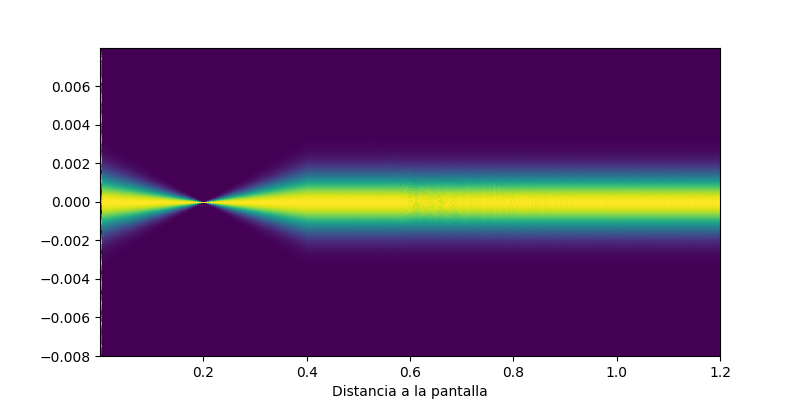

In [4]:

# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.pcolormesh(z,x[::100],np.abs(np.array(IntensityArray).transpose()))  # Representa la intensidad frente a la coordenada espacial

#ax2.plot(x,U1,'r')                # En el nuevo plot dibuja la máscara en color rojo
#ax.set_xlim(-6E-5,6E-5)   
ax.set_xlabel('Distancia a la pantalla')
plt.savefig('SistemaColimador.png')


## Sistema procesador 4F

In [80]:
wl = 633E-9         # Longitud de onda
xmin = -8E-3        # Extremo inferior de la zona de integración
xmax = 8E-3         # Extremo superior de la zona de integración
Nx = 100000         # Número de puntos para la coordenada espacial
x = np.linspace(xmin,xmax,Nx) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Definición de las lentes
lens = Lens(0.2,wl,x)       
lens2 = Lens(0.2,wl,x)

z = np.linspace(1E-5,0.8,300)   # Puntos a lo largo del eje z en los que se calculará la intensidad
IntensityArray = []

mask = Slit(-1.5E-3,2E-3,xmin,xmax,Nx).Slit()+Slit(1.5E-3,2E-3,xmin,xmax,Nx).Slit()

# Recorre todo los puntos en la dirección transversal
# for i, zi in enumerate(z):
    
#     # 
#     if zi <= 0.2:
#         # Se define la distancia de propagación
#         D = zi
        
#         # Campo gaussiano al inicio que atravesar la primera lente 
#         #U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)
#         U1 = Slit(0.0,3E-3,xmin,xmax,Nx).Slit()
#         # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
#         fr = Fresnel(wl,D,xmin,xmax,Nx,U1) 
#         fr.Propagate() # Realiza el cáclulo de la propagación
#         Intensity = fr.ReturnNewIntensity() # Guarda el valor de la intensidad en un vector
        
#         # Normaliza el valor de la intensidad respecto al valor máximo
#         IntensityArray.append(Intensity[::100]/Intensity.max())  


#     elif 0.2<zi<=0.4:
        
#         # Se define el límite de la propagación hasta la posición de la segunda lente
#         D = 0.2
#         #U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)
#         U1 = Slit(0.0,3E-3,xmin,xmax,Nx).Slit()
#         fr = Fresnel(wl,D,xmin,xmax,Nx,U1)
#         fr.Propagate() 
        
#         # Se calcula la propagación hasta la posición zi desde la posición de la segunda lente,
#         # a partir del campo calculado con el primer propagador.
#         D = zi-0.2
#         U2 = (fr.ReturnNewField())*lens.Lens()
#         fr2 = Fresnel(wl,D,xmin,xmax,Nx,U2,flag = 1)
#         fr2.Propagate()
#         Intensity = fr2.ReturnNewIntensity()
#         IntensityArray.append(Intensity[::100]/Intensity.max())
        
#     elif 0.4<zi<=0.6:
        
#         # Se define el límite de la propagación hasta la posición de la segunda lente
#         D = 0.2
#         #U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)
#         U1 = Slit(0.0,3E-3,xmin,xmax,Nx).Slit()
#         fr = Fresnel(wl,D,xmin,xmax,Nx,U1)
#         fr.Propagate() 
        
#         # Se calcula la propagación hasta la posición zi desde la posición de la segunda lente,
#         # a partir del campo calculado con el primer propagador.
#         D = 0.2
#         U2 = (fr.ReturnNewField())*lens.Lens()
#         fr2 = Fresnel(wl,D,xmin,xmax,Nx,U2,flag = 1)
#         fr2.Propagate()
        
#         D = zi-0.4
#         U3 = (fr2.ReturnNewField())*Slit(0.0,0.1E-3,xmin,xmax,Nx).Slit()
#         fr3 = Fresnel(wl,D,xmin,xmax,Nx,U3,flag = 1)
#         fr3.Propagate()
#         Intensity = fr3.ReturnNewIntensity()
#         IntensityArray.append(Intensity[::100]/Intensity.max())
    
        
#     else:
        
# Se define el límite de la propagación hasta la posición de la segunda lente
D = 0.2
#U1 = np.exp(-(x-0.000)*(x-0.000)/4E-6)
U1 = mask
fr = Fresnel(wl,D,xmin,xmax,Nx,U1)
fr.Propagate() 

# Se calcula la propagación hasta la posición zi desde la posición de la segunda lente,
# a partir del campo calculado con el primer propagador.
D = 0.2
U2 = (fr.ReturnNewField())*lens.Lens()
fr2 = Fresnel(wl,D,xmin,xmax,Nx,U2,flag = 1)
fr2.Propagate()

D = 0.2
U3 = (fr2.ReturnNewField())*Slit(0.0,0.3E-3,xmin,xmax,Nx).Slit()
fr3 = Fresnel(wl,D,xmin,xmax,Nx,U3,flag = 1)
fr3.Propagate()

D = 0.8-0.6
U4 = (fr3.ReturnNewField())*lens2.Lens()
Intensity = fr3.ReturnNewIntensity()
fr4 = Fresnel(wl,D,xmin,xmax,Nx,U4,flag = 1)
fr4.Propagate()
Intensity = fr4.ReturnNewIntensity()
IntensityArray.append(Intensity[::100]/Intensity.max())



In [ ]:

# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.pcolormesh(z,x[::100],np.abs(np.array(IntensityArray).transpose()))  # Representa la intensidad frente a la coordenada espacial

#ax2.plot(x,U1,'r')                # En el nuevo plot dibuja la máscara en color rojo
#ax.set_xlim(-6E-5,6E-5)   
ax.set_xlabel('Distancia a la pantalla')
plt.savefig('SistemaLentes.png')


<IPython.core.display.Javascript object>


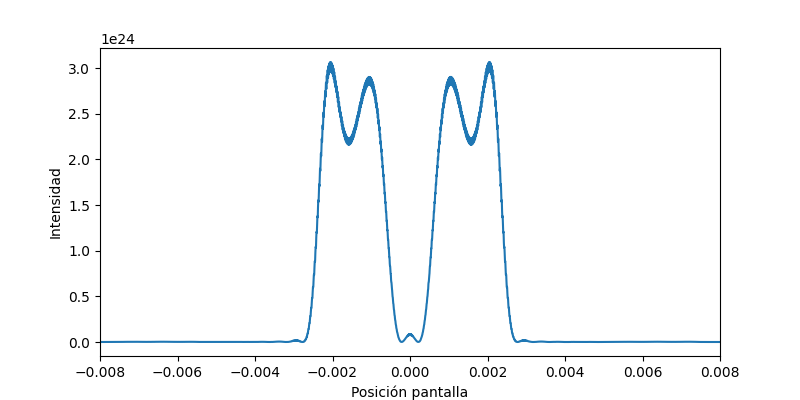

/home/rmhsik/Software/Coherente/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Posición pantalla')

In [81]:
# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.plot(x,fr4.ReturnNewIntensity())  # Representa la intensidad frente a la coordenada espacial
#ax2 = ax.twinx()                    # Crea un sistema de ejes secundarios, compartiendo el eje x entre los dos plots
#ax2.plot(x,mask,'r')                # En el nuevo plot dibuja la máscara en color rojo
ax.set_xlim(-8E-3,8E-3)             # Establece los límites de representación en el eje x
ax.set_ylabel('Intensidad')
ax.set_xlabel('Posición pantalla')
#ax.set_yscale('log')

## Efecto Talbot

In [9]:
wl = 500E-9         # Longitud de onda
xmin = -8E-5        # Extremo inferior de la zona de integración
xmax = 8E-5         # Extremo superior de la zona de integración
Nx = 500000         # Número de puntos para la coordenada espacial
D = 5E-4
x,dx = np.linspace(xmin,xmax,Nx,retstep=True) # Volvemos a crear el array espacial, solamente para poder representar gráficamente

# Define la máscara como una red de difracción binaria
mask1 = Slit(-3.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask2 = Slit(-2.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask3 = Slit(-1.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask4 = Slit(0.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask5 = Slit(1.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask6 = Slit(2.E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask7 = Slit(3.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
#mask8 = Slit(1.5E-5,0.25E-5,xmin,xmax,Nx).Slit()
#mask9 = Slit(2.0E-5,0.25E-5,xmin,xmax,Nx).Slit()
mask = mask1+mask2+mask3+mask4+mask5+mask6+mask7#+mask8+mask9
#U = np.exp(-x*x/1E-5)*lens.Lens()
U1 = mask

z = np.linspace(1E-8,D,600)   # Puntos a lo largo del eje z en los que se calculará la intensidad
IntensityArray = []

# Recorre todo los puntos en la dirección transversal
for i, zi in enumerate(z):
        # Se define la distancia de propagación
        D = zi
        
        # Crea el objeto 'Fresnel' que contendrá todos los elementos para calcular la difracción
        fr = Fresnel(wl,D,xmin,xmax,Nx,U1) 
        fr.Propagate() # Realiza el cáclulo de la propagación
        Intensity = fr.ReturnNewIntensity() # Guarda el valor de la intensidad en un vector
        
        # Normaliza el valor de la intensidad respecto al valor máximo
        # Se cogen valores cada 100 para evitar una representación demasiado pesada
        IntensityArray.append(Intensity[::100]/Intensity.max())  

<IPython.core.display.Javascript object>


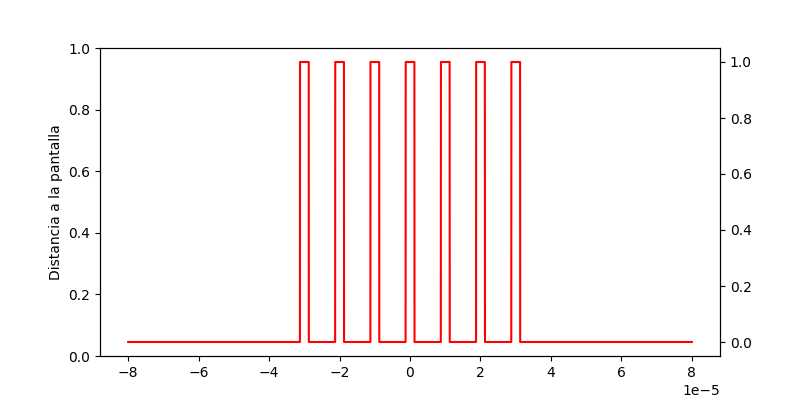

In [10]:

# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
#ax.plot(x,fr.ReturnNewIntensity())  # Representa la intensidad frente a la coordenada espacial
ax2 = ax.twinx()                    # Crea un sistema de ejes secundarios, compartiendo el eje x entre los dos plots
ax2.plot(x,mask,'r')                # En el nuevo plot dibuja la máscara en color rojo
#ax.set_xlim(-6E-3,6E-3)             # Establece los límites de representación en el eje x
ax.set_ylabel('Distancia a la pantalla')
plt.savefig('RedDifraccion.png')

<IPython.core.display.Javascript object>


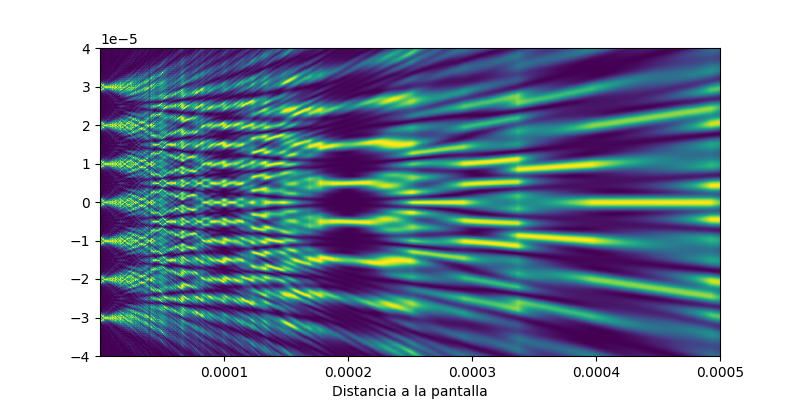

In [16]:
# El código a partir de aquí solamente es para realizar las represetnaciones gáficas
fig = plt.figure(figsize=(8,4))     # Crea el contenedor para todos los plots
ax = fig.add_subplot(111)           # Crea un subplot 
ax.pcolormesh(z,x[::100],np.abs(np.array(IntensityArray).transpose()))  # Representa la intensidad frente a la coordenada espacial

#ax2.plot(x,U1,'r')                # En el nuevo plot dibuja la máscara en color rojo
#ax.set_xlim(-6E-5,6E-5)   
ax.set_xlabel('Distancia a la pantalla')
ax.set_ylim(-4.0E-5,4.0E-5)
plt.savefig('EfectoTalbot.png')
